In [12]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Input, GRU, Dropout
from keras.callbacks import ModelCheckpoint
from keras.saving import load_model

from sklearn.preprocessing import MinMaxScaler

from scripts.process_dataset import read_dataset, read_simulation
from utils import plot_loss, draw_prediction

In [13]:
def get_lookback_model(Na, Nb, X, Y):
    model = Sequential([
        Input(shape=X.shape[1:]),
        GRU(Na, return_sequences=True),
        GRU(Nb),
        Dense(Y.shape[1])
    ])
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(
        "toto.keras",
        #f"{folder_name}/{patch}.keras",  # Filepath to save the best model
        monitor="val_loss",  # Metric to monitor (e.g., validation accuracy)
        save_best_only=True,  # Save only the best model
        mode="min",  # "max" if monitoring validation accuracy, "min" for loss
        verbose=0  # Display messages when saving
    )
    model.fit(X, Y, epochs=50, batch_size=180, validation_split=0.2, verbose=0, callbacks=[checkpoint])
    return model

In [14]:
def moving_predict(X, model, scaler, lookback, time):
    pred = np.zeros((time, X.shape[2]))
    real = np.zeros_like(pred)
    real[:lookback, :] = X_trans[0]
    real[lookback:, :] = X_trans[1:time-lookback+1, -1, :]
    pred[:lookback, :] = X_trans[0]
    for i in range(lookback, time):
        pred[i, :70] = model.predict(pred[i-lookback:i, :].reshape(1, lookback, -1), verbose=0).reshape(-1)
        pred[i, 70:] = X_trans[i-lookback+1, -1, 70:]
    pred = scaler.inverse_transform(pred)
    real = scaler.inverse_transform(real)
    return real, pred

In [15]:
def add_zeros_col_like(Y, X):
    return np.concatenate((Y, np.zeros((Y.shape[0], X.shape[1]-Y.shape[1]))), axis=1)

In [16]:
DATASET_NAME = "toto"
DATASET_PATH = f"../dataset/{DATASET_NAME}"
LOOKBACK = 20
X, Y = read_dataset(f"{DATASET_PATH}/train", LOOKBACK)
X_scaler = read_dataset(f"{DATASET_PATH}/train")[0]
X_scaler = X_scaler.reshape((X_scaler.shape[0], X_scaler.shape[2]))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_scaler)
X_trans = np.zeros_like(X)
for i in range(LOOKBACK):
    X_trans[:, i, :] = scaler.transform(X[:, i, :])
Y_extended = add_zeros_col_like(Y, X_scaler)
Y_trans = scaler.transform(Y_extended)[:, :Y.shape[1]]

In [6]:
Y_trans.shape

(42120, 70)

In [17]:
model_lookback = get_lookback_model(200, 100, X_trans[:, :, :], Y_trans[:, :])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 20, 200)        │       169,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100)            │        90,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 70)             │         7,070 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,870 (1.02 MB)

 Trainable params: 266,870 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

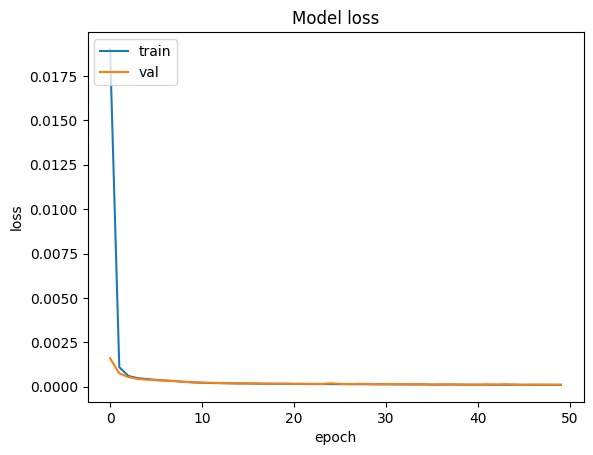

0.00010735864634625614


In [8]:
plot_loss(model_lookback)
print(min(model_lookback.history.history["val_loss"]))

In [10]:
real, pred = moving_predict(X_trans[:, :], model_lookback, scaler, LOOKBACK, 80)
real = scaler.transform(real)
pred = scaler.transform(pred)
print(np.mean(np.square(real-pred)))

0.008258667642204232


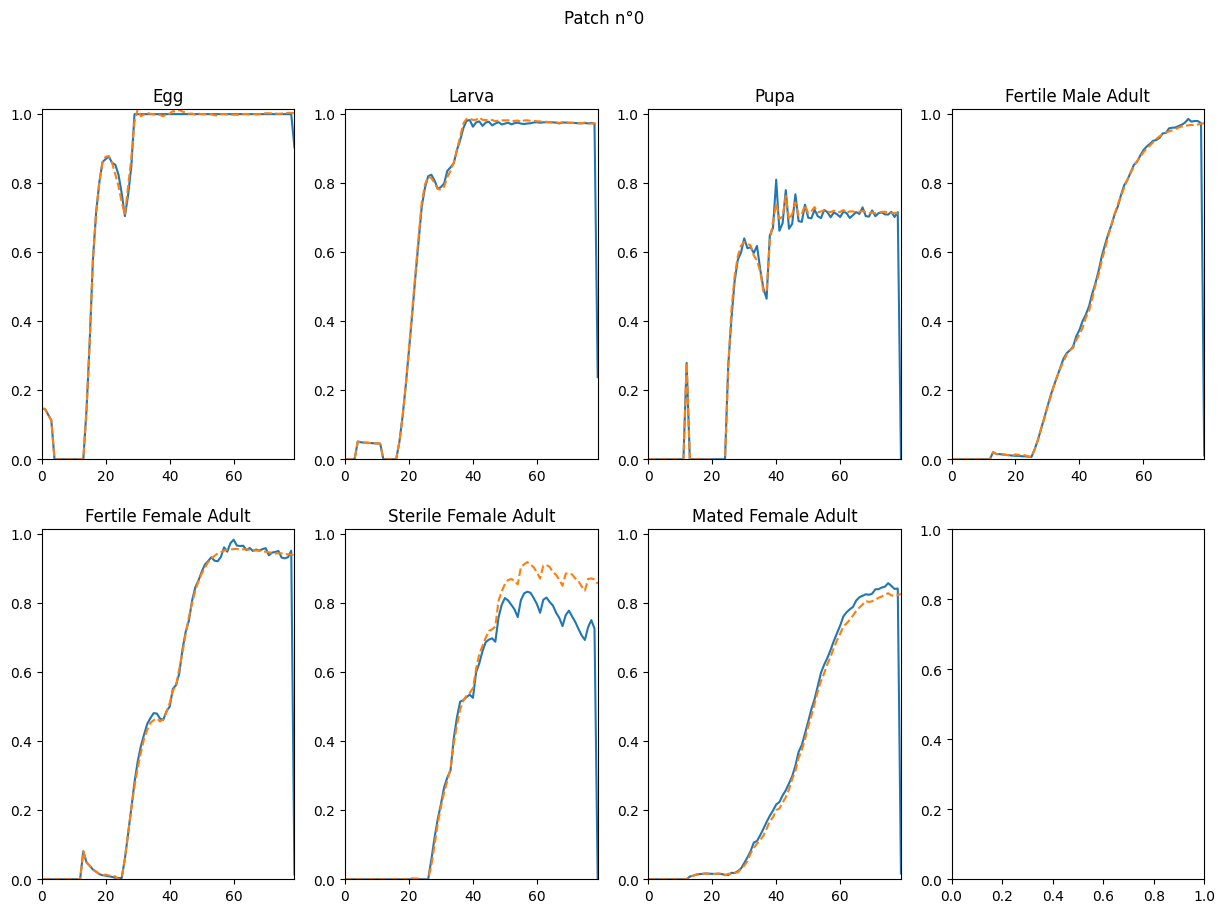

In [11]:
draw_prediction(real, pred, 0)